In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from graphviz import Digraph
%matplotlib inline

In [5]:
class Value:
    def __init__(self, value, _children=(), _op='', label=''):
        self.value = value
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.value})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value + other.value, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * -1.0
    
    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.value * other.value, (self, other), '*')
        def _backward():
            self.grad += other.value * out.grad
            other.grad += self.value * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float for now"
        out = Value(self.value**other, (self,), f'**{other}')
        def _backward():
            self.grad += other * self.value**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.value
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += math.exp(x) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        x = self.value
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for v in reversed(topo):
            v._backward()


In [6]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    print(nodes)
    print(edges)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.value, n.grad), shape='record' )
        if n._op:
            dot.node(name = uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

In [7]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e +c; d.label = 'd'
f = Value(-2.0, label='f')
L = d*f; L.label = 'L'

In [8]:
'''
Chain rule is rule of three in rate perspective for example:
"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast as the man."
Car <--2x--- bicycle <--4x--- walking
Car <--??--- walking
?? = 2 x 4 = 8x

We can do the same with equations for example:
d = a + 4
a = 2 x c

If we want to know how c impact to d (dd/dc), we can visualize like this:
d <------ a <-------- c
Next we need to find rate of c to a and a to d.
a = 2 x c
da/dc = 2 x 1
      = 2

d = a + 4
dd/da = 1 + 0
      = 1

so now that we know the rate:
d <---1x-- a <---2x-- c
dd/dc = da/dc x dd/da = 1 x 2 = 2
'''

'\nChain rule is rule of three in rate perspective for example:\n"If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 x 4 = 8 times as fast as the man."\nCar <--2x--- bicycle <--4x--- walking\nCar <--??--- walking\n?? = 2 x 4 = 8x\n\nWe can do the same with equations for example:\nd = a + 4\na = 2 x c\n\nIf we want to know how c impact to d (dd/dc), we can visualize like this:\nd <------ a <-------- c\nNext we need to find rate of c to a and a to d.\na = 2 x c\nda/dc = 2 x 1\n      = 2\n\nd = a + 4\ndd/da = 1 + 0\n      = 1\n\nso now that we know the rate:\nd <---1x-- a <---2x-- c\ndd/dc = da/dc x dd/da = 1 x 2 = 2\n'

In [9]:
# dL/dL = 1
L.grad = 1.0

# dL/dd = dL/dL * dL/dd = 1 * f = f
d.grad = -2.0

# dL/df = dL/dL * dL/df = 1 * d = f
f.grad = 4

# dL/de = dL/dL * dL/dd * dd/de = 1 * f * 1 = f
e.grad = -2.0

# dL/dc = dL/dL * dL/dd * dd/dc = 1 * f * 1 = f
c.grad = -2.0

# dL/da = dL/dL * dL/dd * dd/de * de/da = 1 * f * 1 * b = f * b
a.grad = 6.0

# dL/db = dL/dL * dL/dd * dd/de * de/db = 1 * f * 1 * a = f * a
b.grad = -4.0

{Value(data=-8.0), Value(data=2.0), Value(data=4.0), Value(data=-2.0), Value(data=10.0), Value(data=-6.0), Value(data=-3.0)}
{(Value(data=-6.0), Value(data=4.0)), (Value(data=4.0), Value(data=-8.0)), (Value(data=10.0), Value(data=4.0)), (Value(data=2.0), Value(data=-6.0)), (Value(data=-3.0), Value(data=-6.0)), (Value(data=-2.0), Value(data=-8.0))}


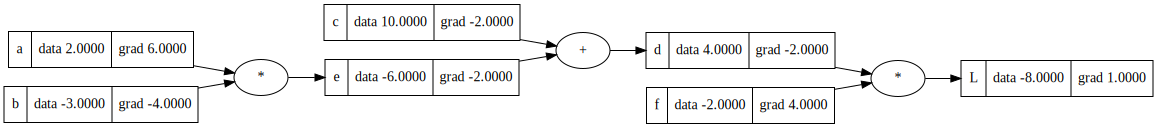

In [10]:
draw_dot(L)

{Value(data=2), Value(data=0.0), Value(data=2.0), Value(data=0.1464466094067262), Value(data=4.828427124746192), Value(data=6.881373587019543), Value(data=1.7627471740390863), Value(data=0.7071067811865477), Value(data=-1), Value(data=1.0), Value(data=-6.0), Value(data=6.828427124746192), Value(data=1), Value(data=-6.0), Value(data=0.0), Value(data=5.828427124746192), Value(data=0.8813735870195432), Value(data=-3.0)}
{(Value(data=5.828427124746192), Value(data=4.828427124746192)), (Value(data=-1), Value(data=4.828427124746192)), (Value(data=-6.0), Value(data=-6.0)), (Value(data=0.8813735870195432), Value(data=1.7627471740390863)), (Value(data=1.7627471740390863), Value(data=5.828427124746192)), (Value(data=0.1464466094067262), Value(data=0.7071067811865477)), (Value(data=-6.0), Value(data=0.8813735870195432)), (Value(data=6.881373587019543), Value(data=0.8813735870195432)), (Value(data=2), Value(data=1.7627471740390863)), (Value(data=5.828427124746192), Value(data=6.828427124746192)), 

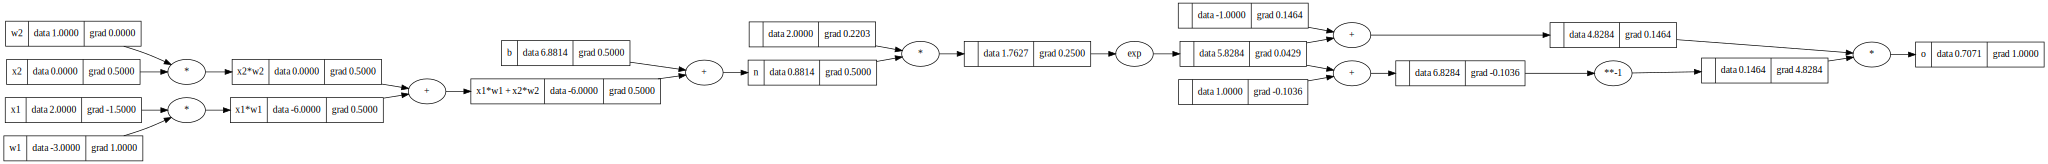

In [13]:
# nerual network without tanh fucntion
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [14]:
import torch

In [15]:
x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.item())
o.backward()
print('------------')
print('x1:', x1.grad.item())
print('x2:', x2.grad.item())
print('w1:', w1.grad.item())
print('w2:', w2.grad.item())


0.7071066904050358
------------
x1: -1.5000003851533106
x2: 0.5000001283844369
w1: 1.0000002567688737
w2: 0.0


In [16]:
class Neuron:
    def __init__(self, n_input):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(n_input)]
        self.b = Value(random.uniform(-1, 1))
    def __call__(self, x):
        action = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = action.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, n_input, n_neuron):
        self.neurons = [Neuron(n_input) for _ in range(n_neuron)]
    def __call__(self, x):
        outs = [neuron(x) for neuron in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, n_input, n_neurons):
        sz = [n_input] + n_neurons
        print('sz:', sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [17]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

sz: [3, 4, 4, 1]


Value(data=0.3217023916974264)

In [18]:
xs = [
    [2.0, 3.0, -1.0],
    [1.0, 2.0, 3.0],
    [0.0, 1.0, 2.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, 0.0, 1.0, 0.0]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.3217023916974264),
 Value(data=-0.7858008321430036),
 Value(data=-0.7534832624611845),
 Value(data=0.18295393803735066)]

In [21]:
for k in range (200):
    # forward
    ypred = [n(x) for x in xs]
    loss = sum((Value(y) - p)**2 for y, p in zip(ys, ypred))

    # backward
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in n.parameters():
        p.value += -0.05 * p.grad
    
    print(loss.value)
    

0.15253573915103685
0.14039105148721107
0.12959453513298339
0.11997239463619792
0.11137452064795507
0.10367134953104738
0.09675108749963791
0.09051725746076858
0.08488655813664765
0.07978699805524357
0.07515628550596064
0.07094044017848555
0.06709260484498535
0.06357202763941273
0.060343194933891446
0.05737509123910064
0.054640569695548896
0.05211581522380734
0.04977988771955571
0.04761433208723512
0.04560284581046322
0.043730994511898005
0.04198596880339142
0.04035637558510951
0.03883205903433092
0.037403946391844745
0.036063915190759695
0.03480467841976161
0.033619685266015525
0.03250303490589225
0.031449401696227085
0.030453969921252166
0.029512376947425704
0.028620663425060987
0.02777522974251544
0.026972797713158737
0.026210376952630027
0.02548523516782256
0.02479487199618423
0.024136995787183823
0.023509503096764653
0.022910460406392847
0.022338087936275893
0.021790745147245084
0.021266917877102925
0.0207652067612515
0.020284316945092806
0.0198230487718859
0.0193802895067924
0.01

In [22]:
ypred

[Value(data=0.9561629656383142),
 Value(data=0.0532796237712156),
 Value(data=0.9545681285354917),
 Value(data=0.046061014689991395)]

{Value(data=0.8012296255952357), Value(data=-1.354227656790347), Value(data=0.809957577303228), Value(data=-0.9070945073224352), Value(data=0.14631441084284463), Value(data=1.0607682555338056), Value(data=-2.2613221641127823), Value(data=0.9562719881460726), Value(data=1.1110778587953094), Value(data=0.7714108247925325), Value(data=0.9053611439528879), Value(data=-0.7715332280590464), Value(data=-0.7531135239621614), Value(data=0.3158408289277658), Value(data=0.7545422836035068), Value(data=-1.3559610201598944), Value(data=0.18473876008702617), Value(data=0.03898926531443356), Value(data=-2.407517746054437), Value(data=0.7322839752732333), Value(data=-0.13864512925583788), Value(data=-0.7816007470619627), Value(data=-0.8197309610881586), Value(data=-0.7839829334462525), Value(data=0.7487075675481563), Value(data=-0.6236770448866611), Value(data=0.04609363083118828), Value(data=-2.4731127369999797), Value(data=-0.5536830108309123), Value(data=0.046061014689991395), Value(data=-1.0), Val

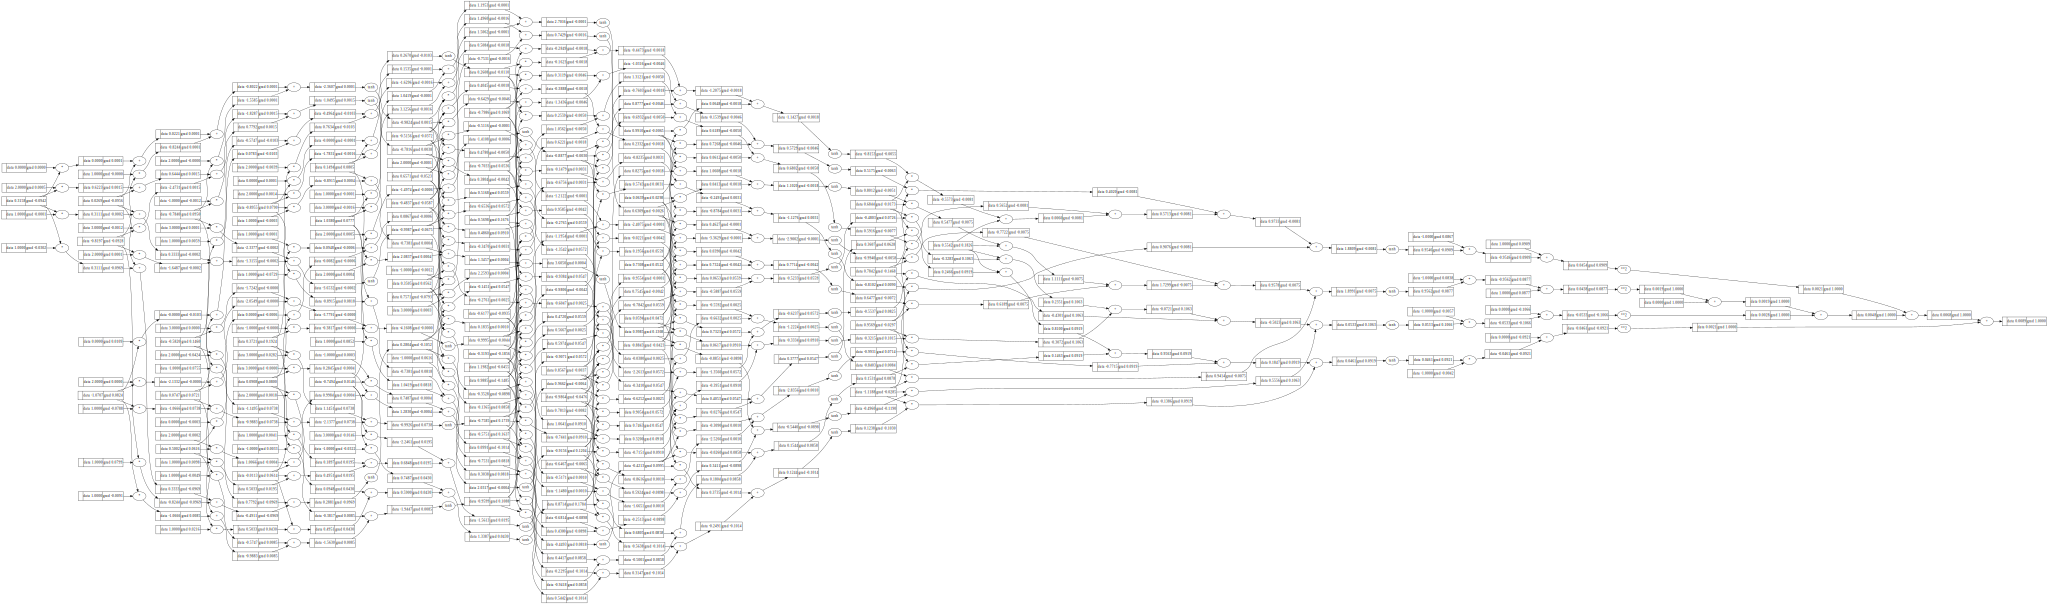

In [23]:
draw_dot(loss)